<a href="https://colab.research.google.com/github/dasparagjyoti/EEG-Channel-Selection-for-Emotion-Recognition/blob/main/Deap_Dataset_for_BCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
def load_eeg(d):
    data = []
    labels = []
    for f in tqdm(range(1,33)):
        if(f < 10):
            s = '0'+str(f)
        else:
            s = str(f)
        tmp = pickle.load(open(d+'/content/gdrive/MyDrive/data_preprocessed_python/'+'s'+s+'.dat','rb'),encoding='latin1')
        data.append(tmp['data'])
        labels.append(tmp['labels'])
    ret = {'data':np.concatenate(data,axis=0),'labels':np.concatenate(labels,axis=0)}

    return ret

In [ ]:
raw_data = load_eeg('')

100%|██████████| 32/32 [02:01<00:00,  3.81s/it]


# **Importing Necessary libraries**

In [ ]:
import os
import time
import pickle
import pandas as pd
import numpy as np

from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import f_oneway


!pip install mne==0.22.0
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
from mne.time_frequency import psd_welch
from mne.decoding import cross_val_multiscore

!pip install fooof
from fooof import FOOOFGroup
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.plts.spectra import plot_spectrum

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

     |████████████████████████████████| 6.9 MB 4.5 MB/s 
     |████████████████████████████████| 112 kB 5.2 MB/s 


In [ ]:
!ls /content/gdrive/MyDrive/data_preprocessed_python

s01.dat  s05.dat  s09.dat  s13.dat  s17.dat  s21.dat  s25.dat  s29.dat
s02.dat  s06.dat  s10.dat  s14.dat  s18.dat  s22.dat  s26.dat  s30.dat
s03.dat  s07.dat  s11.dat  s15.dat  s19.dat  s23.dat  s27.dat  s31.dat
s04.dat  s08.dat  s12.dat  s16.dat  s20.dat  s24.dat  s28.dat  s32.dat


In [ ]:
with open('/content/gdrive/MyDrive/data_preprocessed_python/s01.dat', 'rb') as f:
 x = pickle.load(f, encoding='latin1')
 print(x)

{'labels': array([[7.71, 7.6 , 6.9 , 7.83],
       [8.1 , 7.31, 7.28, 8.47],
       [8.58, 7.54, 9.  , 7.08],
       [4.94, 6.01, 6.12, 8.06],
       [6.96, 3.92, 7.19, 6.05],
       [8.27, 3.92, 7.  , 8.03],
       [7.44, 3.73, 7.08, 7.04],
       [7.32, 2.55, 6.32, 5.87],
       [4.04, 3.29, 3.62, 5.99],
       [1.99, 4.86, 2.04, 7.09],
       [2.99, 2.36, 3.63, 6.24],
       [2.71, 2.77, 3.4 , 7.35],
       [1.95, 3.12, 2.87, 6.18],
       [4.18, 2.24, 3.04, 5.04],
       [3.17, 8.08, 2.91, 5.04],
       [6.81, 7.44, 8.15, 7.14],
       [2.46, 6.91, 6.77, 6.41],
       [7.23, 7.15, 6.94, 8.01],
       [7.17, 8.  , 8.1 , 6.79],
       [8.26, 7.91, 7.19, 8.13],
       [9.  , 7.95, 8.37, 7.86],
       [7.09, 2.08, 7.06, 7.37],
       [8.15, 3.01, 7.37, 7.9 ],
       [7.04, 7.09, 8.01, 8.22],
       [8.86, 7.21, 8.65, 7.21],
       [7.28, 7.27, 7.41, 8.24],
       [7.35, 6.95, 7.03, 7.29],
       [3.88, 3.35, 4.01, 7.87],
       [1.36, 2.27, 3.  , 8.14],
       [2.08, 2.99, 3.22, 7.33],

# **Read Data**

In [ ]:
with open('/content/gdrive/MyDrive/s08.dat', 'rb') as f:
 x = pickle.load(f, encoding='latin1')
 print(x)

{'labels': array([[7.6 , 6.78, 7.86, 7.47],
       [5.04, 6.51, 5.65, 6.32],
       [8.15, 6.96, 7.33, 7.96],
       [6.82, 8.23, 5.  , 8.12],
       [4.41, 7.72, 5.62, 6.67],
       [7.4 , 7.26, 5.94, 7.04],
       [5.04, 5.04, 5.04, 4.95],
       [8.82, 6.4 , 6.31, 8.53],
       [8.78, 7.24, 6.35, 8.22],
       [4.97, 3.6 , 6.94, 3.77],
       [8.41, 5.  , 5.12, 7.54],
       [8.47, 6.54, 4.01, 8.19],
       [7.9 , 5.09, 3.9 , 8.1 ],
       [6.88, 4.97, 5.12, 7.38],
       [8.33, 5.04, 5.17, 7.31],
       [4.21, 5.06, 5.  , 6.24],
       [6.67, 4.77, 5.04, 6.6 ],
       [7.21, 4.03, 5.44, 6.64],
       [5.04, 6.28, 5.04, 5.81],
       [6.74, 4.21, 6.44, 7.08],
       [4.68, 6.41, 6.27, 7.33],
       [4.23, 5.79, 1.19, 7.79],
       [3.59, 3.68, 3.44, 6.6 ],
       [4.15, 4.56, 3.35, 7.86],
       [3.72, 3.9 , 3.5 , 7.71],
       [4.99, 4.99, 5.04, 7.44],
       [4.46, 4.59, 6.65, 6.21],
       [5.04, 4.96, 5.04, 8.68],
       [2.78, 2.99, 3.62, 7.15],
       [1.4 , 3.13, 1.21, 7.95],

In [ ]:
data = x['data']
labels = x['labels']

print("Labels: ", labels.shape) # trial x label
print("Data: ", data.shape) # trial x channel x data

Labels:  (40, 4)
Data:  (40, 40, 8064)


# **1. Reduce 40 40 8064 to 40 32 7860 For 32 take the first 32 and for 7860 , discards the first 384 data points.** 

In [ ]:
import numpy as np

data_arr = x['data']
reduced_data = data_arr[:, :32, 384:8064]
print(reduced_data )

[[[ 7.00425391e-01  8.14980134e+00  3.06306274e+01 ... -3.15271080e+00
   -5.83038929e+00 -4.19324653e+00]
  [ 8.42451407e+00 -1.65371803e+00 -1.06964161e+01 ... -8.70884714e+00
   -7.93627151e+00 -7.86581746e-01]
  [-9.91144563e+00 -1.33157450e+00 -1.34027759e+01 ... -4.20581538e+00
   -2.66122680e+00  4.72850113e+00]
  ...
  [-1.07711577e+01 -8.82173304e+00 -2.92466888e-02 ... -8.23329381e+00
   -3.44109923e+00 -7.49174582e+00]
  [ 9.38777516e+00 -2.85749642e+00 -7.35469439e+00 ...  8.67118503e+00
    8.41429462e+00 -3.72031896e+00]
  [ 1.78406843e+01  1.37371718e+00 -6.01279983e+00 ...  1.32310877e+01
    7.52977608e+00 -4.27201131e+00]]

 [[-7.61039433e+00 -4.03907991e+00  1.51675829e+01 ... -8.18521757e+00
   -4.09266842e+00  2.70881085e+00]
  [-3.77285919e+01 -1.28140707e+01  1.73913058e+01 ... -7.62173910e+00
   -5.97627783e-01 -4.63622259e-01]
  [-7.67032065e+00 -3.52341337e+00 -1.73769932e+00 ... -2.44656389e+00
   -4.38318352e+00 -7.69548673e+00]
  ...
  [-2.96772706e+01 -7.6

In [ ]:
reduced_data.shape

(40, 32, 7680)

#**2. Discretize the labels Rating 1-5: as low valence /low arousal Rating 6-9: high valence/high arousal**

In [ ]:
# Only extract Valence and Arousal ratings
df_label_ratings = pd.DataFrame({'Valence': labels[:,0], 'Arousal': labels[:,1]})
print(df_label_ratings.describe())

         Valence    Arousal
count  40.000000  40.000000
mean    5.399750   5.523250
std     2.053065   1.471928
min     1.210000   2.990000
25%     4.225000   4.582500
50%     5.040000   5.050000
75%     6.962500   6.617500
max     8.820000   8.230000


In [ ]:
print(df_label_ratings.head(15))

    Valence  Arousal
0      7.60     6.78
1      5.04     6.51
2      8.15     6.96
3      6.82     8.23
4      4.41     7.72
5      7.40     7.26
6      5.04     5.04
7      8.82     6.40
8      8.78     7.24
9      4.97     3.60
10     8.41     5.00
11     8.47     6.54
12     7.90     5.09
13     6.88     4.97
14     8.33     5.04


In [ ]:
# High Arousal High Valence dataset
df_hahv = df_label_ratings[(df_label_ratings['Valence'] >= np.median(labels[:,0])) & (df_label_ratings['Arousal'] >= np.median(labels[:,1]))]
# Low Arousal High Valence dataset
df_lahv = df_label_ratings[(df_label_ratings['Valence'] >= np.median(labels[:,0])) & (df_label_ratings['Arousal'] < np.median(labels[:,1]))]
# High Arousal Low Valence dataset
df_halv = df_label_ratings[(df_label_ratings['Valence'] < np.median(labels[:,0])) & (df_label_ratings['Arousal'] >= np.median(labels[:,1]))]
# Low Arousal Low Valence dataset
df_lalv = df_label_ratings[(df_label_ratings['Valence'] < np.median(labels[:,0])) & (df_label_ratings['Arousal'] < np.median(labels[:,1]))]

In [ ]:
print(df_lalv)

    Valence  Arousal
9      4.97     3.60
22     3.59     3.68
23     4.15     4.56
24     3.72     3.90
25     4.99     4.99
26     4.46     4.59
28     2.78     2.99
29     1.40     3.13
37     4.72     4.69
39     3.13     5.03


In [ ]:
print(df_hahv) 

    Valence  Arousal
0      7.60     6.78
1      5.04     6.51
2      8.15     6.96
3      6.82     8.23
5      7.40     7.26
7      8.82     6.40
8      8.78     7.24
11     8.47     6.54
12     7.90     5.09
18     5.04     6.28
31     6.33     8.23
33     5.05     6.83


In [ ]:
# Check nummber of trials per each group
print("High Valence:", str(len(df_hahv) + len(df_lahv)))
print("Low Valence:", str(len(df_halv) + len(df_lalv)))
print("High Arousal:", str(len(df_hahv) + len(df_halv)))
print("Low Arousal:", str(len(df_lahv) + len(df_lalv)))

High Valence: 22
Low Valence: 18
High Arousal: 20
Low Arousal: 20


In [ ]:
# Check nummber of trials per each group
print("High Arousal High Valence:", str(len(df_hahv)))
print("Low Arousal High Valence:", str(len(df_lahv)))
print("High Arousal Low Valence:", str(len(df_halv)))
print("Low Arousal Low Valence:", str(len(df_lalv)))

High Arousal High Valence: 12
Low Arousal High Valence: 10
High Arousal Low Valence: 8
Low Arousal Low Valence: 10


# **1. Bandpass Filtering** 


### Separate EEG and non-EEG data

The dataset includes 32 EEG channels and 8 peripheral physiological channels. The peripheral signals include: electrooculogram (EOG), electromyograms (EMG) of Zygomaticus and Trapezius muscles, GSR, respiration amplitude, blood volume by plethysmograph, skin temperature.

In [ ]:
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])
peripheral_channels = np.array(["hEOG", "vEOG", "zEMG", "tEMG", "GSR", "Respiration belt", "Plethysmograph", "Temperature"])

In [ ]:
eeg_data = []
for i in range (len(data)):
  for j in range (len(eeg_channels)):
    eeg_data.append(data[i,j])
eeg_data = np.reshape(eeg_data, (len(data), len(eeg_channels), len(data[0,0])))
print(eeg_data.shape)

(40, 32, 8064)


In [ ]:
print(eeg_data)

[[[  2.44585256  -1.46814149  -1.8110823  ...  -3.1527108   -5.83038929
    -4.19324653]
  [ -4.83047016  -2.56698426   0.89973395 ...  -8.70884714  -7.93627151
    -0.78658175]
  [ -2.4436984   -1.5793379   -2.19903389 ...  -4.20581538  -2.6612268
     4.72850113]
  ...
  [ -4.92648536  -1.24204101   2.5972898  ...  -8.23329381  -3.44109923
    -7.49174582]
  [  3.44692111   2.02830423   1.22193318 ...   8.67118503   8.41429462
    -3.72031896]
  [  4.01716961   1.9467513    0.10599802 ...  13.23108772   7.52977608
    -4.27201131]]

 [[  2.60995133   0.7153333   -5.00704773 ...  -8.18521757  -4.09266842
     2.70881085]
  [-28.85776075 -13.16460388  -2.84107869 ...  -7.6217391   -0.59762778
    -0.46362226]
  [-12.36270157 -11.73258804 -12.53318263 ...  -2.44656389  -4.38318352
    -7.69548673]
  ...
  [ 28.09336272  18.58154236   2.31110766 ...  -0.79262588   7.62617933
    11.30113604]
  [ 29.97587902  25.28178947  16.22131258 ...   4.78589026   1.09460904
     1.83539325]
  [ 16.6

In [ ]:
peripheral_data = []
for i in range (len(data)):
  for j in range (32,len(data[0])):
    peripheral_data.append(data[i,j])
peripheral_data = np.reshape(peripheral_data, (len(data), len(peripheral_channels), len(data[0,0])))
print(peripheral_data.shape)

(40, 8, 8064)


#**Welch's feature extraction**



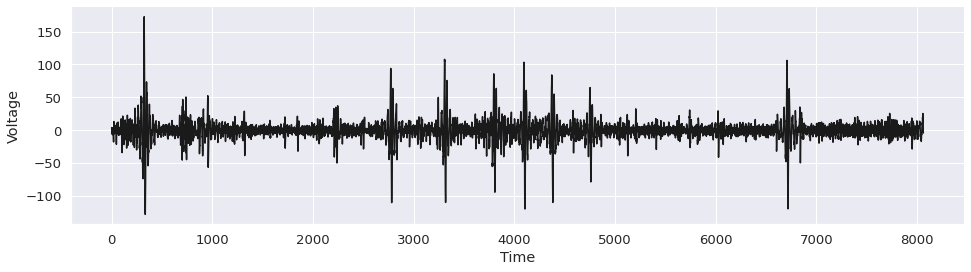

In [ ]:
sns.set(font_scale=1.2)

# Define sampling frequency and time vector
sf = 100
time = np.arange(eeg_data.size) / sf

# Plot the signal of first trial, last channel 
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(eeg_data[0,31], lw=1.5, color='k') 
plt.xlabel('Time')
plt.ylabel('Voltage')
sns.despine()

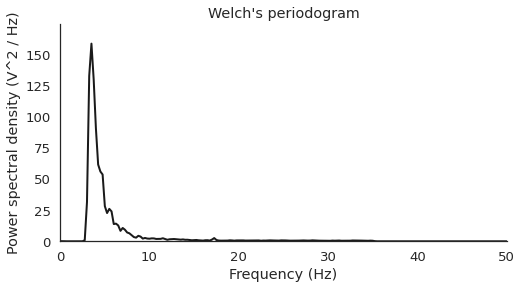

In [ ]:
# Define window length (4 seconds)
win = 4 * sf
freqs, psd = signal.welch(eeg_data[0,31], sf, nperseg=win)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()

#*Delta Band Power(0.5-4)Hz*

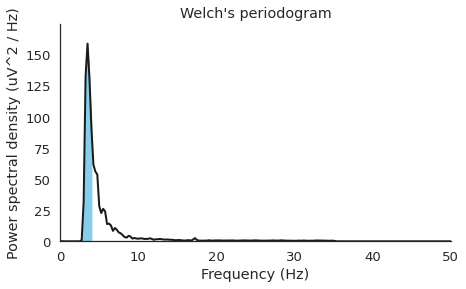

In [ ]:
# Define delta lower and upper limits
low, high = 0.5, 4

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

In [ ]:
print(idx_delta)

[False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [ ]:
idx_delta.shape

(201,)

#*Theta Band Power(4-8)Hz*

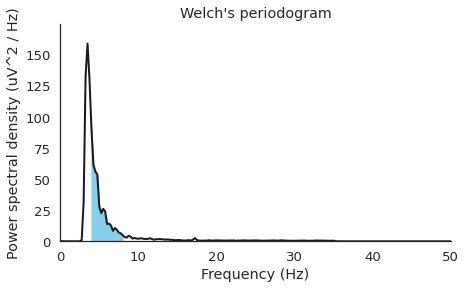

In [ ]:
# Define delta lower and upper limits
low, high = 4, 8

# Find intersecting values in frequency vector
idx_theta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

In [ ]:
print(idx_theta)
idx_theta.shape

[False False False False False False False False False False False False
 False False False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

(201,)

#*Alpha Band Power(8-12)Hz*

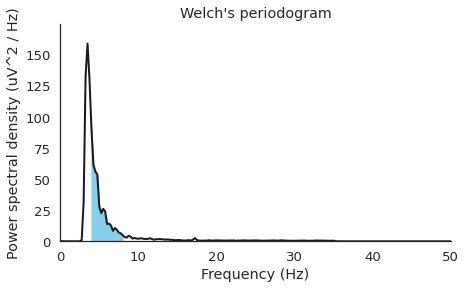

In [ ]:
# Define delta lower and upper limits
low, high = 8, 12

# Find intersecting values in frequency vector
idx_d = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the alpha area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

#*Beta Band Power(12-30)Hz*

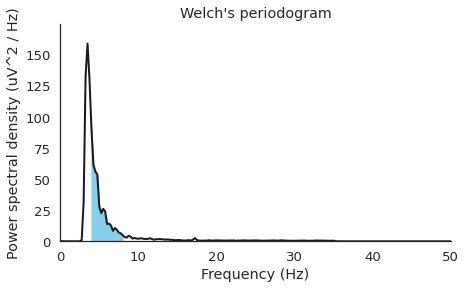

In [ ]:
# Define beta lower and upper limits
low, high = 12, 30

# Find intersecting values in frequency vector
idx_beta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the beta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

#*Gamma Band Power(30-45)Hz*

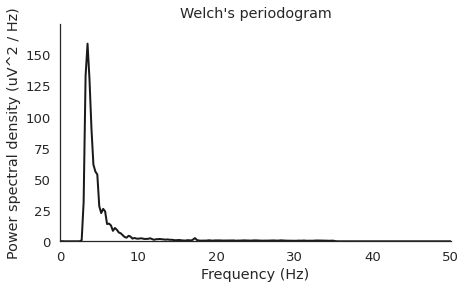

In [ ]:
# Define gamma lower and upper limits
low, high = 30, 45

# Find intersecting values in frequency vector
idx_gamma = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the gamma area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_gamma, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

#**Removal of noise using Independent Component Analysis**

In [ ]:
info = mne.create_info(32, sfreq=128)
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, ...
 chs: 32 MISC
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>


In [ ]:
info = mne.create_info(eeg_channels.tolist(), ch_types=32*['eeg'], sfreq=128)
info.set_montage('standard_1020')
print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF3, F3, F7, FC5, FC1, C3, T7, CP5, CP1, P3, P7, PO3, O1, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>


In [ ]:
raw_data = mne.io.RawArray(eeg_data[31], info)

Creating RawArray with float64 data, n_channels=32, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.


In [ ]:
print(raw_data)

<RawArray | 32 x 8064 (63.0 s), ~2.0 MB, data loaded>


#**Filtering Data Through Bandpass**

In [ ]:
# # Cut off frequency at 30hz
filt = raw_data.filter(0.5,45, method='iir')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 45.00 Hz: -6.02, -6.02 dB



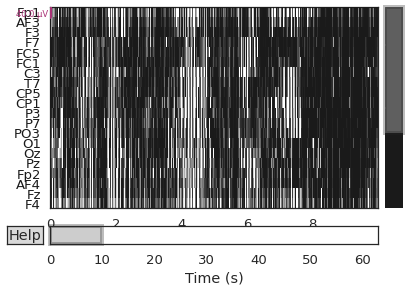

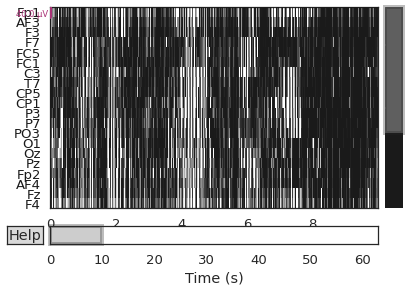

In [ ]:
filt.plot()

In [ ]:
import mne
#raw = mne.io.read_raw_edf('chb04_07.edf', preload=True)
#raw.drop_channels(['T8-P8'])
#raw.save('chb04_07_raw.fif')
raw_data.save('eeg_data_raw.fif')

Writing /content/eeg_data_raw.fif
Closing /content/eeg_data_raw.fif
[done]


In [ ]:
# Plot sensor positions
montage = mne.channels.make_standard_montage("biosemi32")
raw_data.set_montage(montage)
montage.plot()

NameError: ignored

Effective window size : 16.000 (s)


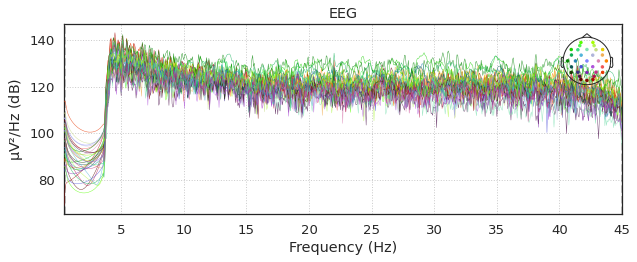

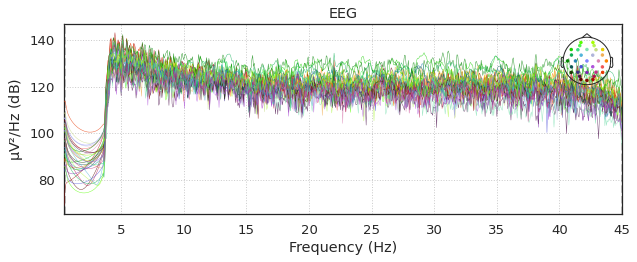

In [ ]:
# Plot the power spectral density across channels
mne.viz.plot_raw_psd(raw_data, fmin = 0.4, fmax= 45)

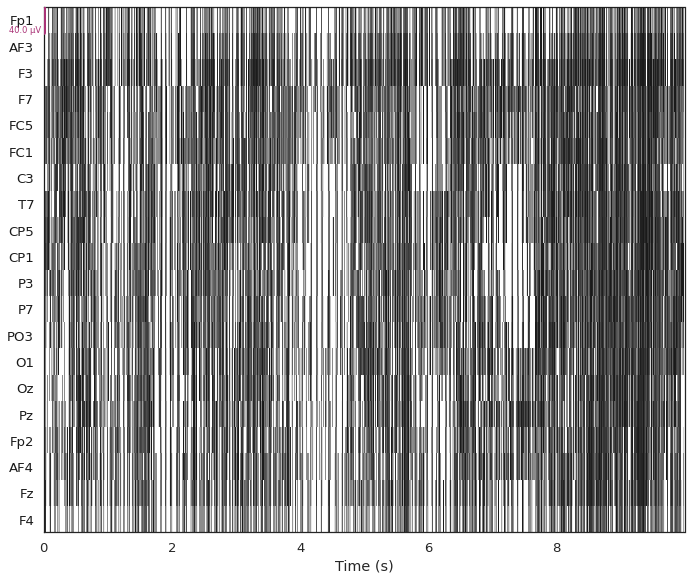

In [ ]:
#Plotting raw eeg signals
plt.rcParams["figure.figsize"] = [10,8]
mne.io.Raw.plot(self=raw_data, show_scrollbars=False);

In [ ]:
# Checking info for channel names, frequency
info = raw_data.info
print(raw_data)
print(raw_data.info)

NameError: ignored

In [ ]:
# Checking Dictionary keys
print(info.keys())
print()  # insert a blank line
print(info['ch_names'])

dict_keys(['acq_pars', 'acq_stim', 'ctf_head_t', 'description', 'dev_ctf_t', 'dig', 'experimenter', 'utc_offset', 'device_info', 'file_id', 'highpass', 'hpi_subsystem', 'kit_system_id', 'helium_info', 'line_freq', 'lowpass', 'meas_date', 'meas_id', 'proj_id', 'proj_name', 'subject_info', 'xplotter_layout', 'gantry_angle', 'bads', 'chs', 'comps', 'events', 'hpi_meas', 'hpi_results', 'projs', 'proc_history', 'custom_ref_applied', 'sfreq', 'dev_head_t', 'ch_names', 'nchan'])

['Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO3', 'O1', 'Oz', 'Pz', 'Fp2', 'AF4', 'Fz', 'F4', 'F8', 'FC6', 'FC2', 'Cz', 'C4', 'T8', 'CP6', 'CP2', 'P4', 'P8', 'PO4', 'O2']


In [ ]:
# Checking keys for the channels
print(info['chs'])

[{'loc': array([-0.02933873,  0.09029533,  0.03683328,  0.        ,  0.        ,
        0.        ,         nan,         nan,         nan,         nan,
               nan,         nan]), 'unit_mul': 0 (FIFF_UNITM_NONE), 'range': 1.0, 'cal': 1.0, 'kind': 2 (FIFFV_EEG_CH), 'coil_type': 1 (FIFFV_COIL_EEG), 'unit': 107 (FIFF_UNIT_V), 'coord_frame': 4 (FIFFV_COORD_HEAD), 'ch_name': 'Fp1', 'scanno': 1, 'logno': 1}, {'loc': array([-0.03859344,  0.0827639 ,  0.06633428,  0.        ,  0.        ,
        0.        ,         nan,         nan,         nan,         nan,
               nan,         nan]), 'unit_mul': 0 (FIFF_UNITM_NONE), 'range': 1.0, 'cal': 1.0, 'kind': 2 (FIFFV_EEG_CH), 'coil_type': 1 (FIFFV_COIL_EEG), 'unit': 107 (FIFF_UNIT_V), 'coord_frame': 4 (FIFFV_COORD_HEAD), 'ch_name': 'AF3', 'scanno': 2, 'logno': 2}, {'loc': array([-0.05177571,  0.06393767,  0.08764873,  0.        ,  0.        ,
        0.        ,         nan,         nan,         nan,         nan,
               nan,  

In [ ]:
# Confirming EEG channels
eeg_ch = mne.pick_channels(info['ch_names'], include=['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 
                                                   'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 
                                                   'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz'])
print(eeg_ch)

#eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


In [ ]:
# Setting aside SSP Projectors in a separate variable and deleting them
ssp_projectors = raw_data.info['projs']
raw_data.del_proj()

<RawArray | 32 x 8064 (63.0 s), ~2.0 MB, data loaded>

In [ ]:
# Plotting and Observing Low Frequency Drifts and Blinks
plt.rcParams["figure.figsize"] = [10,8];
fig = plt.figure(figsize=(500, 400));
raw_data.plot(duration=60, remove_dc=False, show_scrollbars=False);

NameError: ignored

Effective window size : 16.000 (s)


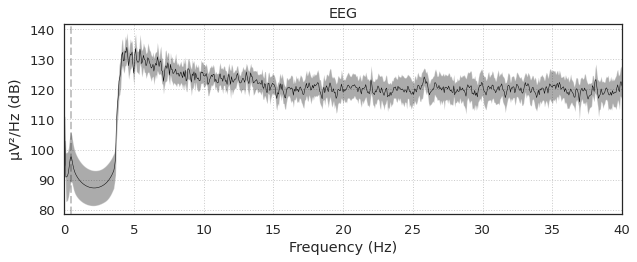

In [ ]:
# Checking For Power Line Disturbances
plt.rcParams["figure.figsize"] = [10,8]
fig = raw_data.plot_psd(tmax=np.inf, fmax=40, average=True)
# add some arrows at 60 Hz and its harmonics:
for ax in fig.axes[1:]:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    for freq in (60, 120, 180, 240):
        idx = np.searchsorted(freqs, freq)
        ax.arrow(x=freqs[idx], y=psds[idx] + 18, dx=0, dy=-12, color='red',
                 width=0.1, head_width=3, length_includes_head=True);

In [ ]:
ica = mne.preprocessing.ICA(n_components=32, random_state=0)

In [ ]:
filter_data = ica.fit(raw_data.copy().filter(0.5, 45))

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 sec)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 2.2s.


<ipython-input-44-4b8b926dcaf7>:1: RuntimeWarning: Using n_components=32 (resulting in n_components_=32) may lead to an unstable mixing matrix estimation because the ratio between the largest (17) and smallest (7e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 31
  filter_data = ica.fit(raw_data.copy().filter(0.5, 45))


In [ ]:
print(filter_data)

<ICA | raw data decomposition, fit (fastica): 8064 samples, 32 components, channels used: "eeg">


Effective window size : 16.000 (s)


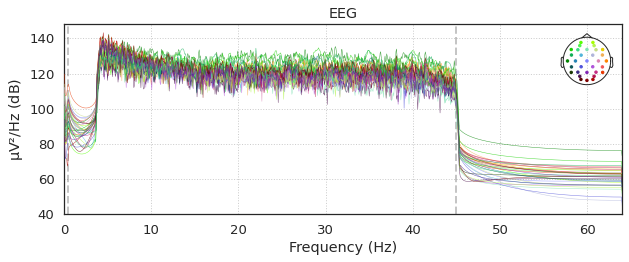

In [ ]:
# Plotting the power spectral density
filt_raw = raw_data.copy()
plt.rcParams["figure.figsize"] = [10,8]
raw_data.plot_psd(picks='eeg');

In [ ]:
print(filt_raw)

<RawArray | 32 x 8064 (63.0 s), ~2.0 MB, data loaded>


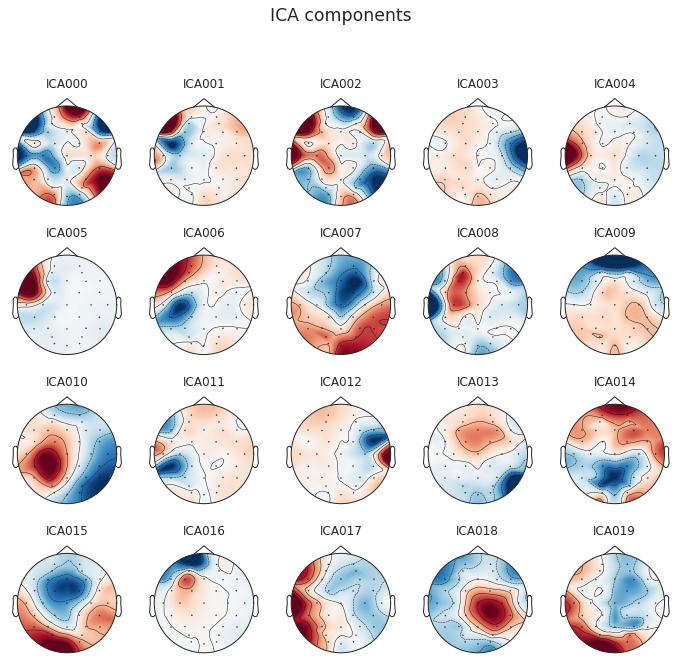

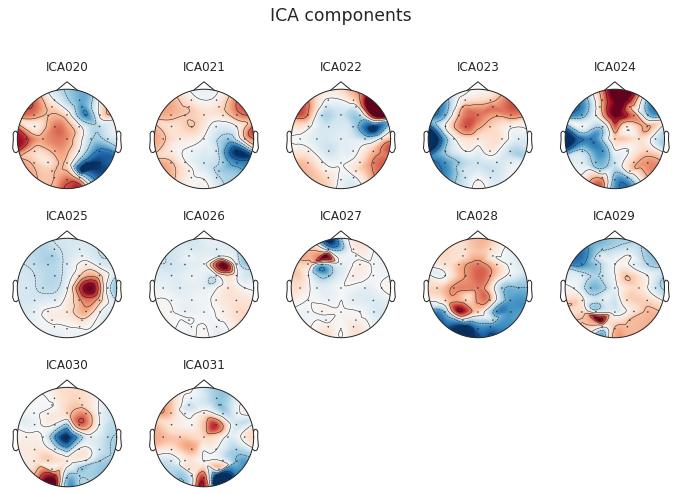

[<Figure size 702x678.24 with 20 Axes>, <Figure size 702x508.68 with 12 Axes>]

In [ ]:
# Plotting Scalp Field Distribution of each component
ica.plot_components()

#**Common Average Reference**

In [ ]:
raw_data.set_eeg_reference()  

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


<RawArray | 32 x 8064 (63.0 s), ~2.0 MB, data loaded>

 **To set the reference to the default that came with the headset**

In [ ]:
raw_data.set_eeg_reference([]) 

EEG channel type selected for re-referencing
EEG data marked as already having the desired reference.


<RawArray | 32 x 8064 (63.0 s), ~2.0 MB, data loaded>

**To set the reference to a custom combination of electrodes**

In [ ]:
raw_data.set_eeg_reference(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])  

EEG channel type selected for re-referencing
Applying a custom EEG reference.


<RawArray | 32 x 8064 (63.0 s), ~2.0 MB, data loaded>

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


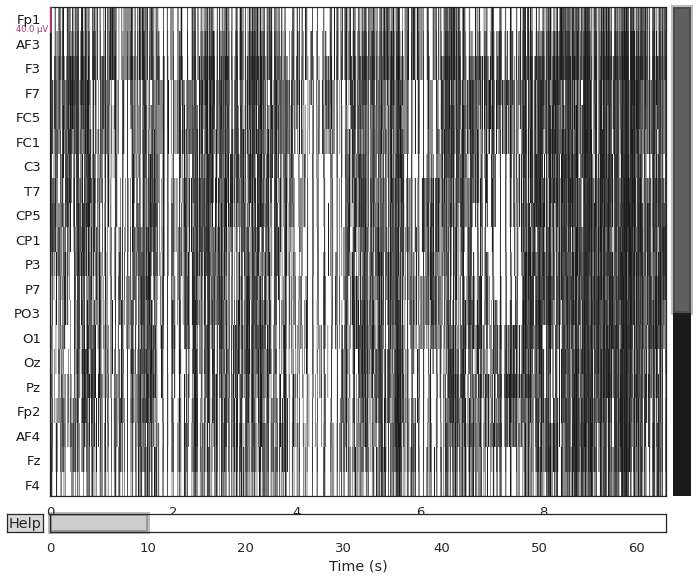

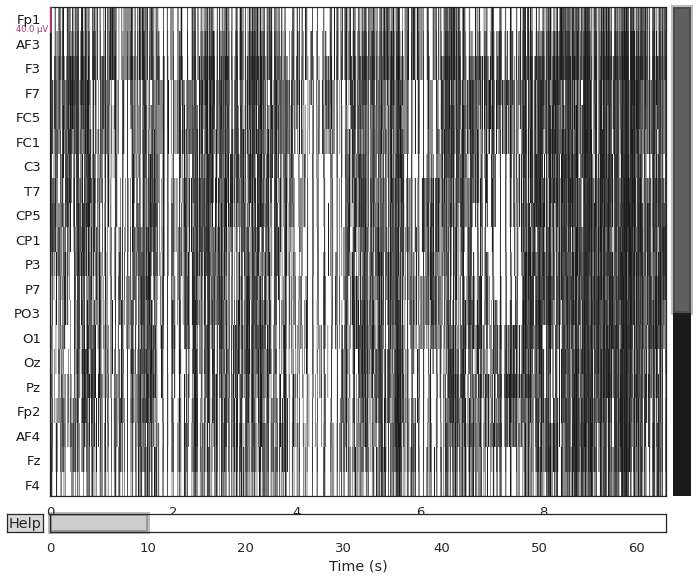

In [ ]:
raw_avg_ref = raw_data.copy().set_eeg_reference(ref_channels='average')
raw_avg_ref.plot()

In [ ]:
raw_data.set_eeg_reference('average', projection=True)
print(raw_data.info['projs'])

[<Projection | Average EEG reference, active : False, n_channels : 32>]


<ipython-input-60-08415627d584>:1: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw_data.set_eeg_reference('average', projection=True)


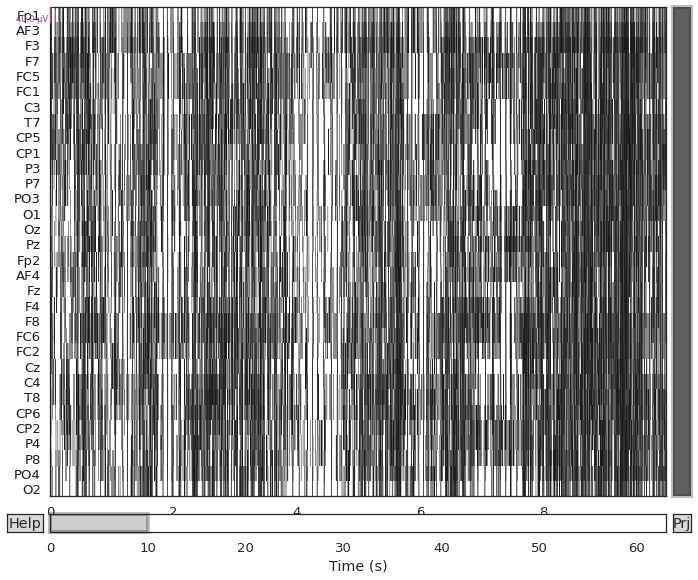

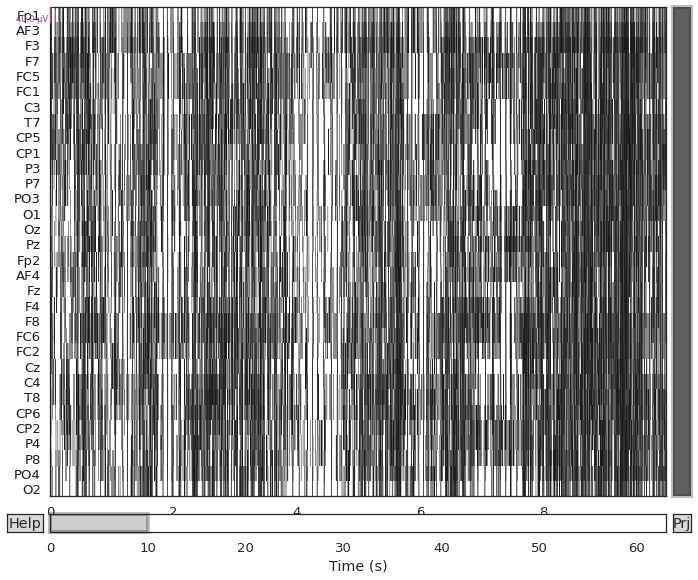

In [ ]:
for title, proj in zip(['Original', 'Average'], [False, True]):
    fig = raw_data.plot(proj=proj, n_channels=len(raw_data))
    # make room for title
    fig.subplots_adjust(top=0.9)
    fig.suptitle('{} reference'.format(title), size='xx-large', weight='bold')

#NEW PRACTICE 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/MyDrive/data_preprocessed_python

s01.dat  s05.dat  s09.dat  s13.dat  s17.dat  s21.dat  s25.dat  s29.dat
s02.dat  s06.dat  s10.dat  s14.dat  s18.dat  s22.dat  s26.dat  s30.dat
s03.dat  s07.dat  s11.dat  s15.dat  s19.dat  s23.dat  s27.dat  s31.dat
s04.dat  s08.dat  s12.dat  s16.dat  s20.dat  s24.dat  s28.dat  s32.dat


In [ ]:
import os
import time
import pickle
import pandas as pd
import numpy as np

from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import f_oneway

from tqdm import tqdm

!pip install mne==0.22.0
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
from mne.time_frequency import psd_welch
from mne.decoding import cross_val_multiscore

!pip install fooof
from fooof import FOOOFGroup
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.plts.spectra import plot_spectrum

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

     |████████████████████████████████| 6.9 MB 5.0 MB/s 
     |████████████████████████████████| 112 kB 5.3 MB/s 


In [ ]:
# Function to load data from each participant file
def read_eeg_signal_from_file(filename):
    x = pickle._Unpickler(open(filename, 'rb'))
    x.encoding = 'latin1'
    p = x.load()
    return p

In [ ]:
# Load only 22/32 participants with frontal videos recorded
files = []
for n in range(1, 33): 
    s = ''
    if n < 10:
        s += '0'
    s += str(n)
    files.append(s)
print(files)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']


In [ ]:
# 22x40 = 880 trials for 22 participants
labels = []
data = []

for i in files: 
  filename = "/content/gdrive/MyDrive/data_preprocessed_python/s" + i + ".dat"
  trial = read_eeg_signal_from_file(filename)
  labels.append(trial['labels'])
  data.append(trial['data'])

# Re-shape arrays into desired shapes
labels = np.array(labels)
labels = labels.flatten()
labels = labels.reshape(1280, 4)

data = np.array(data)
data = data.flatten()
data = data.reshape(1280, 40, 8064)

In [ ]:
# Double-check the new arrays
print("Labels: ", labels.shape) # trial x label
print("Data: ", data.shape) # trial x channel x data

Labels:  (1280, 4)
Data:  (1280, 40, 8064)


In [ ]:
print(data)

[[[ 9.48231681e-01  1.65333533e+00  3.01372577e+00 ... -2.82648937e+00
   -4.47722969e+00 -3.67692812e+00]
  [ 1.24706590e-01  1.39008270e+00  1.83509881e+00 ... -2.98702069e+00
   -6.28780884e+00 -4.47429041e+00]
  [-2.21651099e+00  2.29201682e+00  2.74636923e+00 ... -2.63707760e+00
   -7.40651010e+00 -6.75590441e+00]
  ...
  [ 2.30779684e+02  6.96716323e+02  1.19512165e+03 ...  1.01080949e+03
    1.28312149e+03  1.51996480e+03]
  [-1.54180981e+03 -1.61798052e+03 -1.69268642e+03 ... -1.57842691e+04
   -1.57823160e+04 -1.57808512e+04]
  [ 6.39054310e-03  6.39054310e-03  6.39054310e-03 ... -9.76081241e-02
   -9.76081241e-02 -9.76081241e-02]]

 [[ 1.02601750e+01  1.27954427e+01  1.04261916e+01 ...  6.02219406e+00
    7.53913583e+00  9.35224904e+00]
  [ 9.49186875e+00  1.25897704e+01  1.05740268e+01 ...  6.03399490e+00
    9.06874552e+00  8.74021419e+00]
  [ 7.12867480e+00  1.22064700e+01  9.49646701e+00 ...  6.17971667e+00
    6.93374514e+00  6.48086477e+00]
  ...
  [ 1.91950410e+03  3.5

In [ ]:
print(labels)

[[7.71 7.6  6.9  7.83]
 [8.1  7.31 7.28 8.47]
 [8.58 7.54 9.   7.08]
 ...
 [3.05 7.01 5.1  1.1 ]
 [3.99 7.17 4.85 1.  ]
 [7.15 4.03 9.   1.88]]


In [ ]:
reduced_data  = data[:, :32, 384:8064]
reduced_data.shape

(1280, 32, 7680)

### Separate EEG and non-EEG data

The dataset includes 32 EEG channels and 8 peripheral physiological channels. The peripheral signals include: electrooculogram (EOG), electromyograms (EMG) of Zygomaticus and Trapezius muscles, GSR, respiration amplitude, blood volume by plethysmograph, skin temperature.

In [ ]:
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])
peripheral_channels = np.array(["hEOG", "vEOG", "zEMG", "tEMG", "GSR", "Respiration belt", "Plethysmograph", "Temperature"])

In [ ]:
eeg_data = []
for i in range (len(reduced_data)):
  for j in range (len(eeg_channels)):
    eeg_data.append(reduced_data[i,j])
eeg_data = np.reshape(eeg_data, (len(reduced_data), len(eeg_channels), len(reduced_data[0,0])))
print(eeg_data.shape)

(1280, 32, 7680)


In [ ]:
peripheral_data = []
for i in range (len(data)):
  for j in range (32,len(data[0])):
    peripheral_data.append(data[i,j])
peripheral_data = np.reshape(peripheral_data, (len(data), len(peripheral_channels), len(data[0,0])))
print(peripheral_data.shape)

(1280, 8, 8064)


In [ ]:
info = mne.create_info(ch_names=("Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"), sfreq=128, ch_types='eeg')
#info = mne.create_info(32, sfreq=128)
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF3, F3, F7, FC5, FC1, C3, T7, CP5, CP1, P3, P7, PO3, O1, ...
 chs: 32 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>


In [ ]:
raw_data_array = mne.io.RawArray(eeg_data[32], info)

Creating RawArray with float64 data, n_channels=32, n_times=7680
    Range : 0 ... 7679 =      0.000 ...    59.992 secs
Ready.


In [ ]:
print(raw_data_array)

<RawArray | 32 x 7680 (60.0 s), ~1.9 MB, data loaded>


In [ ]:
# Checking info for channel names, frequency
info = raw_data_array.info
print(raw_data_array)
print(raw_data_array.info)

<RawArray | 32 x 7680 (60.0 s), ~1.9 MB, data loaded>
<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF3, F3, F7, FC5, FC1, C3, T7, CP5, CP1, P3, P7, PO3, O1, ...
 chs: 32 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>


In [ ]:
filt = raw_data_array.filter(0.5,45, method='iir')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 45.00 Hz: -6.02, -6.02 dB



/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


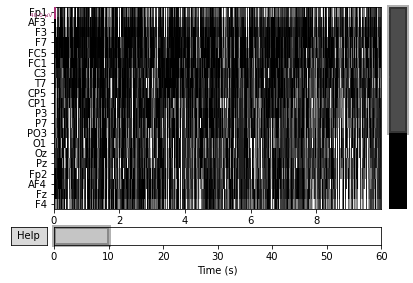

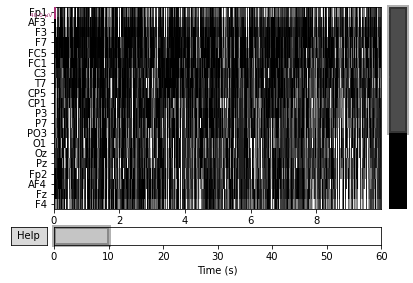

In [ ]:
filt.plot()

###**1.6 Removal of artifacts using Independent Component Analysis(ICA)**

In [ ]:
ica = mne.preprocessing.ICA(n_components=32, random_state=0)

In [ ]:
filter_data = ica.fit(filt.copy().filter(0.5, 45))

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 sec)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 2.3s.


<ipython-input-32-d48a07f6c9df>:1: RuntimeWarning: Using n_components=32 (resulting in n_components_=32) may lead to an unstable mixing matrix estimation because the ratio between the largest (13) and smallest (7.1e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 31
  filter_data = ica.fit(filt.copy().filter(0.5, 45))


In [ ]:
print(filter_data)

<ICA | raw data decomposition, fit (fastica): 7680 samples, 32 components, channels used: "eeg">


Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 0 ICA components
    Projecting back using 32 PCA components


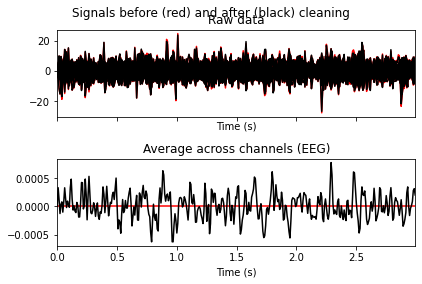

In [ ]:
ica.plot_overlay(filt, picks='eeg');

###**1.7 Filtering through Common Average Reference(CAR)**

In [ ]:
filter_data.set_eeg_reference()  

AttributeError: ignored

 **To set the reference to the default that came with the headset**

In [ ]:
raw_data_array.set_eeg_reference([]) 

EEG channel type selected for re-referencing
EEG data marked as already having the desired reference.


<RawArray | 32 x 7680 (60.0 s), ~1.9 MB, data loaded>

**To set the reference to a custom combination of electrodes**

In [ ]:
raw_data_array.set_eeg_reference(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])  

EEG channel type selected for re-referencing
Applying a custom EEG reference.


<RawArray | 32 x 7680 (60.0 s), ~1.9 MB, data loaded>

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


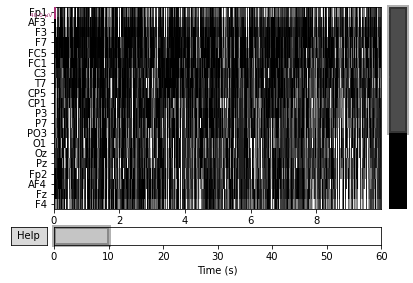

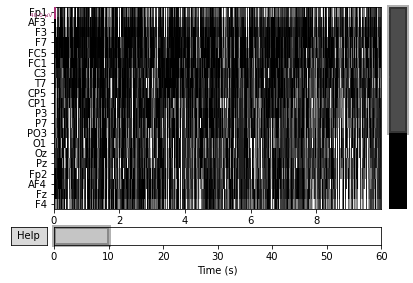

In [ ]:
raw_avg_ref = raw_data_array.copy().set_eeg_reference(ref_channels='average')
raw_avg_ref.plot()

In [ ]:
raw_data_array.set_eeg_reference('average', projection=True)
print(raw_data_array.info['projs'])

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
[<Projection | Average EEG reference, active : False, n_channels : 32>]


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


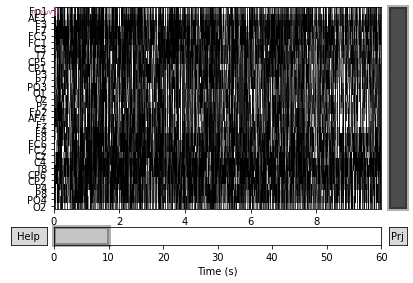

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


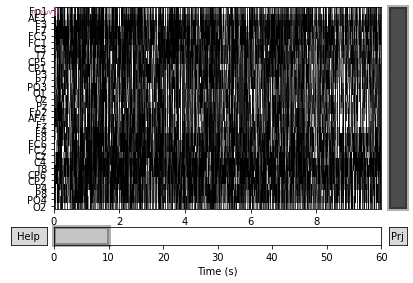

In [ ]:
for title, proj in zip(['Original', 'Average'], [False, True]):
    fig = raw_data_array.plot(proj=proj, n_channels=len(raw_data_array))
    # make room for title
    fig.subplots_adjust(top=0.9)
    fig.suptitle('{} reference'.format(title), size='xx-large', weight='bold')

### Welch's feature extraction

For the EEG data, we use Welch's method to extract theta, alpha, beta, and gamma spectral
power for each electrode. The frequency bands used:
theta (4 - 8 Hz), alpha (8 - 12 Hz), beta (12 - 30 Hz),
and gamma (30 - 64 Hz).

In [ ]:
sns.set(font_scale=1.2)

# Define sampling frequency and time vector
sf = 128.
time = np.arange(filt.size) / sf

# Plot the signal of first trial, last channel 
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(eeg_data[0,31], lw=1.5, color='k') 
plt.xlabel('Time')
plt.ylabel('Voltage')
sns.despine()

AttributeError: ignored

#### Delta band power

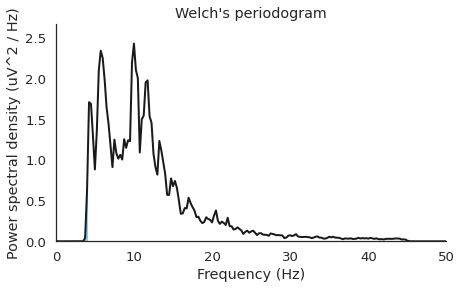

In [ ]:
# Define theta lower and upper limits
low, high = 0.5, 4

# Find intersecting values in frequency vector
idx_theta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the theta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_theta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

#### Alpha band power

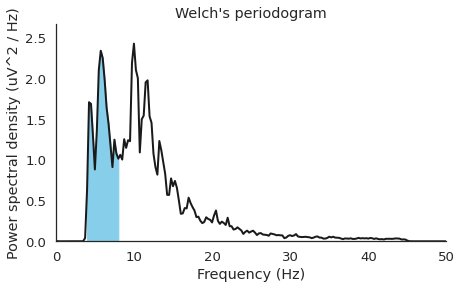

In [ ]:
# Define alpha lower and upper limits
low, high = 4, 8

# Find intersecting values in frequency vector
idx_alpha = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the alpha area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_alpha, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

#### Beta band power

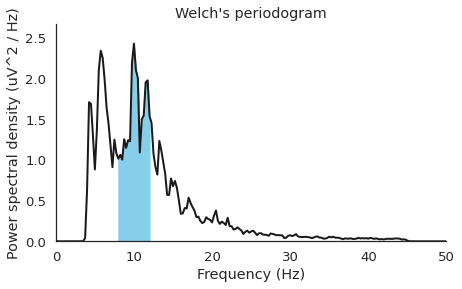

In [ ]:
# Define beta lower and upper limits
low, high = 8,12

# Find intersecting values in frequency vector
idx_beta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the beta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_beta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

#### Gamma band power

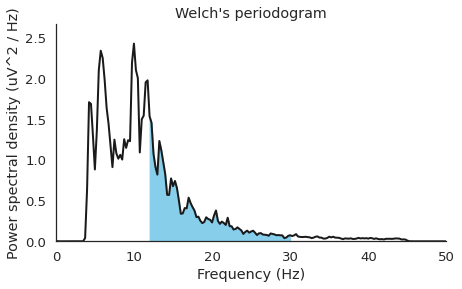

In [ ]:
# Define delta lower and upper limits
low, high = 12, 30

# Find intersecting values in frequency vector
idx_gamma = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the gamma area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_gamma, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

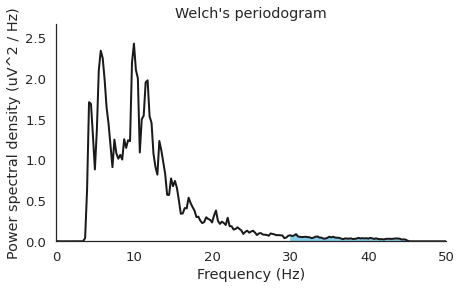

In [ ]:
# Define delta lower and upper limits
low, high = 30, 45

# Find intersecting values in frequency vector
idx_gamma = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the gamma area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_gamma, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()